<a href="https://colab.research.google.com/github/Bookas1468/data-science-google-colab/blob/main/exercises/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

No. elpd_loo only compares models to eachother.

**Task2**:

Describe overfitting, in the context of this course

Overfitting is adjusting your model to fit your data very well but making it so focused on your data that it can't be applied to other data of the same types. Overfitting is an issue because it actually makes your model less accurate to the real world by making too close to what your inherently limited dataset represents

**Task3**:

How do we mitigate overfitting?

Having weak priors helps mitigate overfitting. Weak priors allow the model to be more generically applicable instead of being more tightly bound to you assumptions.

**Task4**:

How do we mitigate underfitting?

To mitigate underfitting you could use a more accurate distribution or better informing the model with more data or better priors.

**Task5**:

Why would we want more than one predictor in a model?

Things in the real world have a lot of causes. By adding more predictors you can more closely simulate the real world since there will be more information to inform the model.

**Task6**:

Can we have too many predictors? How would we know?

Having too many predictors, especially ones that may not be relevant to the data, results in overfitting the model so that it doesn't accurately represent reality but instead represents one dataset. You can tell by the model not representing a different set of data very well. It will also limit the model based on a variable that isn't relevant to it, further decreasing accuracy.

**Task7**:

What is variable selection, and how does it work?

Variable selection is the process by which variables are chosen to be used for a model. This is done by making a causal diagram and then making a model with all of the variables in the causal diagram present in it. Use that model and comapre its elpd_loo to models with some variables removed to find which one has the best elpd_loo while still making logical sense and being realistic.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

Adding the variables in the model can result in your model being less accurate due to it failing to filter for potentially vast differences between categories. By instead using the categorical variable as a hierarchy, the other predictor variable will account for those categories and be more accurate. If you add the variables and use categorical interactions then you get a mix of the two since the model will still be using the categories but it will also have data that accounts for that.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

Multiple linear regression models can be visualized by adding more axis of variance, such as color. Eventually we will run out of axis that can be used effectively so we need to take a "slice" of the model and then combine the slices to represent the model.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install bambi
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 14.0 MB/s eta 0:00:00


In [3]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
    ).dropna()

In [4]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)
bb.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
6,Jarrett Allen,C,25,CLE,77,77,2442,519,819,0.634,...,243,568,811,210,53,81,121,147,1271,allenja01
8,Jose Alvarado,PG,25,NOP,56,0,1028,142,345,0.412,...,25,103,128,117,59,15,40,89,397,alvarjo01
9,Kyle Anderson,PF,30,MIN,79,10,1782,199,433,0.460,...,60,213,273,331,71,47,91,128,506,anderky01
10,Giannis Antetokounmpo,PF,29,MIL,73,73,2567,837,1369,0.611,...,196,645,841,476,87,79,250,210,2222,antetgi01
12,Cole Anthony,PG,23,ORL,81,0,1817,332,763,0.435,...,64,247,311,236,64,37,126,175,937,anthoco01


In [ ]:
#priors ={"FT%" : bmb.Prior("HalfNormal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_nbb_bmb = bmb.Model("FGp ~ Pos + FTp", bb, family = "gaussian")

idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_nbb_bmb2 = bmb.Model("FGp ~ (FTp | Pos)", bb, family = "gaussian")

idata_nbb_bmb2 = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_nbb_bmb3 = bmb.Model("FGp ~ FTp + Pos + FTp:Pos", bb, family = "gaussian")

idata_nbb_bmb3 = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_nbb_bmb4 = bmb.Model("FGp ~ FTp + Pos + `3PA` + FTp:Pos + FTp:`3PA` + Pos:`3PA`", bb, family = "gaussian")

idata_nbb_bmb4 = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_nbb_bmb5 = bmb.Model("FGp ~ FTp + Pos + `3PA` + Pos:`3PA`", bb, family = "gaussian")

idata_nbb_bmb5 = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

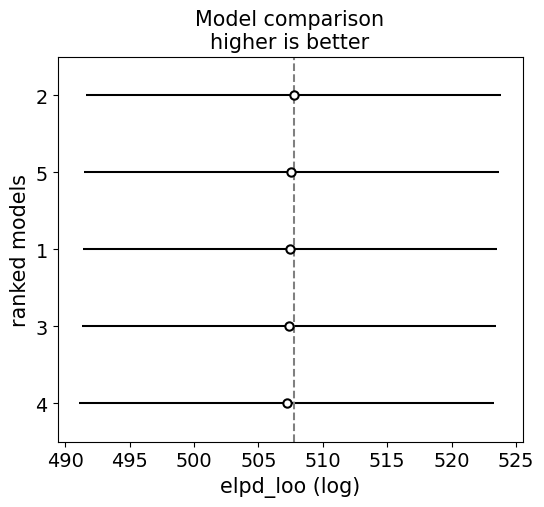

In [10]:
comparer = az.compare({"1":idata_nbb_bmb,"2":idata_nbb_bmb2,"3":idata_nbb_bmb3,"4":idata_nbb_bmb4,"5":idata_nbb_bmb5})

az.plot_compare(comparer)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

According to my models the second was the best. I think this is because it doesn't include 3 point attempts (which probably won't impact the percentage of field goals scored) and it still accounts for position by using it as a heirarchy.

**Task12:**

The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

Create a sensible causal diagram for this set of variables.

Based on your causal diagram, which variable should you try to predict? Why?

In [11]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [12]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


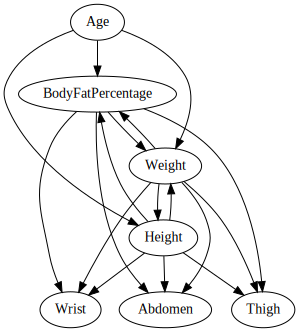

In [13]:
Causal = gv.Digraph(name="causal diagram")

Causal.node('f',"BodyFatPercentage")
Causal.node('a',"Age")
Causal.node('w',"Weight")
Causal.node('h',"Height")
Causal.node('b',"Abdomen")
Causal.node('t',"Thigh")
Causal.node('r',"Wrist")

Causal.edges(['af','wf','hf','ah','hw','wh','fb','ft','fr','ht','hr','hb','aw','wr','wt','wb','fw'])
Causal

I think you could try to predict either body fat percentage since the predictors that lead into it are pretty simple. You could also try to predict wrist/abdomen/thigh but those have a lot more complexity due to being influenced by body fat percentage so it might be harder to have clear predictors.